## Getting LASERBALL SNO data to compare against


In [23]:
import ROOT, rat
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
%matplotlib inline   


In [2]:
outdir = '/home/jp/Dropbox/workflowy/snoplus/greydisc_modeling/laserball_sno'

In [3]:
sys.path.append('/home/jp/projects/snoplus/snoing/install/rat-dev/example/pyroot')
sys.path.append('/home/jp/projects/python_tools')
sys.path.append('/home/jp/projects/snoplus/python_modules')

In [4]:
import jp_mpl as jplot
import lowlevel_stats
reload(lowlevel_stats)

TClass::TClass:0: RuntimeWarning: no dictionary for class RAT::DU::ShadowingCalculator is available


<module 'lowlevel_stats' from '/home/jp/projects/snoplus/python_modules/lowlevel_stats.pyc'>

In [5]:
data_dir = '/home/jp/projects/snoplus/data/sno/laserball_data'
file_list = [os.path.join(data_dir, x) for x in os.listdir(data_dir)]

In [6]:
tfile = ROOT.TFile(file_list[0])

In [7]:
keys = tfile.GetListOfKeys()

In [8]:
for one_key in keys:
    print one_key

<ROOT.TKey object ("fRchTime") at 0x4050800>
<ROOT.TKey object ("fRchQhs") at 0x4050950>
<ROOT.TKey object ("fRchQhl") at 0x4050aa0>
<ROOT.TKey object ("fRchQlx") at 0x4050c50>
<ROOT.TKey object ("fRchQvsT") at 0x4050e00>
<ROOT.TKey object ("fRchToF") at 0x4050fb0>
<ROOT.TKey object ("source_pos") at 0x4051160>
<ROOT.TKey object ("cast") at 0x4051320>
<ROOT.TKey object ("lambda") at 0x40514e0>
<ROOT.TKey object ("version") at 0x40516a0>
<ROOT.TKey object ("RSPS") at 0x4051860>
<ROOT.TKey object ("ChanEff") at 0x4051a20>


In [9]:
key = tfile.Get('lambda')

In [10]:
one_key.GetName()

'ChanEff'

In [11]:
avoid_prefix = "fRch"
def getLaserballInfo(one_file):
    tfile = ROOT.TFile(one_file)    
    data = {'name': one_file}
    for one_key in tfile.GetListOfKeys():
        #print one_key.GetName()
        if avoid_prefix in one_key.GetName():
            continue
            
        data[one_key.GetName()] = np.array(tfile.Get(one_key.GetName()))
        #print one_key.GetName()
    tfile.Close()
    return data

In [12]:
def getLaserballPosition(one_file):
    tfile = ROOT.TFile(one_file)
    spos = np.array(tfile.Get('source_pos'))
    tfile.Close()
    return spos

In [13]:
def getLaserballTOA(one_file, key_name = 'fRchTime'):

    tfile = ROOT.TFile(one_file)
    
    # Getting the info out of this one file
    caltime = tfile.Get(key_name)
    caltime_x = caltime.ProjectionX()
    rootaxis = caltime_x.GetXaxis()
    
    nbins = caltime_x.GetNbinsX()
    binc = np.zeros(nbins)
    xaxis = np.zeros(nbins+1)
    
    #print nbins
    for ibin in range(nbins):
        binc[ibin]  = caltime_x.GetBinContent(ibin)
        xaxis[ibin] = rootaxis.GetBinLowEdge(ibin)
    xaxis[nbins] = rootaxis.GetBinLowEdge(nbins)   
    tfile.Close()
    #print xaxis, xaxis.shape
    #print binc, binc.shape
    return binc, xaxis    

In [66]:
positions = np.zeros([len(file_list), 4])
for i, one_file in enumerate(file_list):
    positions[i,:] = getLaserballPosition(one_file)

-124.38755895 265.2915806 705.219970703
192.389695512 141.326706567 638.150236917


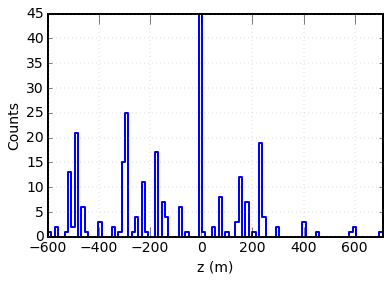

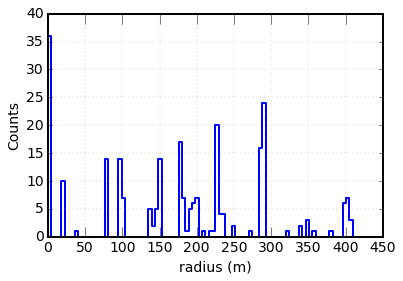

In [67]:
data = positions[:,2]
print data.mean(), data.std(), data.max()
b,x = np.histogram(data, np.linspace(-600, 710, 101))
plt.figure()
jplot.unfilledBar(x,b)
plt.xlabel('z (m)')
plt.ylabel('Counts')

data = np.sqrt(np.sum(positions[:,:2]**2,axis=1))
print data.mean(), data.std(), data.max()
plt.figure()
b,x = np.histogram(data, np.linspace(0, 450, 101))
jplot.unfilledBar(x,b)
plt.xlabel('radius (m)')
plt.ylabel('Counts')

In [75]:
minrad = 0

# Select a couple of very different xyz coordinates
radii = np.sqrt(np.sum(positions[:,:2]**2,axis=1))
#print positions[:,:3].shape

selection = ((abs(positions[:,2])< 20)*
             (radii <minrad+20)*(radii>minrad))
#selection = ((positions[:,2] <  -450)*
#             (radii > 100)*(radii<150))

print np.sum(selection)

#selection = ((abs(positions[:,0])>150) *
#             (abs(positions[:,1])>150) *
#             (abs(positions[:,2])>200))
#print np.sum(selection)
indices = np.where(selection)[0]
print 'Selected indices', indices

13
Selected indices [  3   7   9  51  76  82 111 143 146 169 231 237 256]


0.712307711633 2.61312125296 9.76000022888
1.02217378364 0.260471438616 1.30862518614


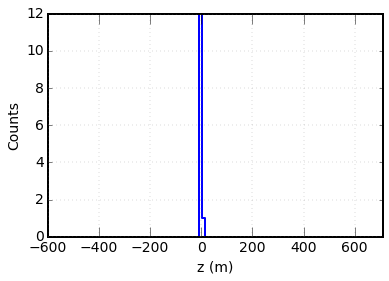

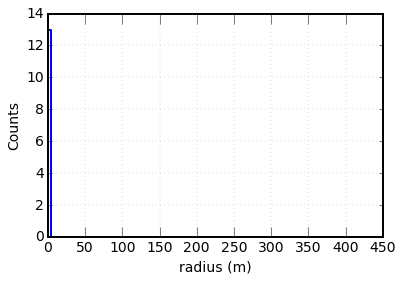

In [76]:
data = positions[selection,2]
print data.mean(), data.std(), data.max()
b,x = np.histogram(data, np.linspace(-600, 710, 101))
plt.figure()
jplot.unfilledBar(x,b)
plt.xlabel('z (m)')
plt.ylabel('Counts')

data = np.sqrt(np.sum(positions[selection,:2]**2,axis=1))
print data.mean(), data.std(), data.max()
plt.figure()
b,x = np.histogram(data, np.linspace(0, 450, 101))
jplot.unfilledBar(x,b)
plt.xlabel('radius (m)')
plt.ylabel('Counts')

In [77]:
# Figure out the data for those files
run_info = []
for index in indices:
    run_info.append(getLaserballInfo(file_list[index]))

In [78]:
# Selecting those with similar settings
test_files = []
test_wavelength = 500#500 #386. #337.
for i in range(len(run_info)):
    if abs(run_info[i]['lambda'][1] - test_wavelength) < 0.5:
        test_files.append(run_info[i]['name'])
print len(test_files)

7


Position  [ -1.29999995  -0.15000001  -0.16        99.98955536]
0.837685032895 0.624897203947


/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide


Position  [ -0.          -1.21000004   0.          99.7257843 ]
0.850534539474 0.624897203947
Position  

/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in divide


[  9.99999978e-03  -1.12000000e+00  -1.99999996e-02   9.96797180e+01]
0.861842105263 0.453465743441
Skipping one file
Skipping one file
Position  [ -1.01999998e+00  -7.99999982e-02  -1.29999995e-01   9.98203888e+01]
0.837685032895 0.455415747266
Position  [ -1.01999998e+00  -9.99999978e-03   1.70000002e-01   9.96971512e+01]
0.859169407895 0.453140665995


(0.5, 1.5)

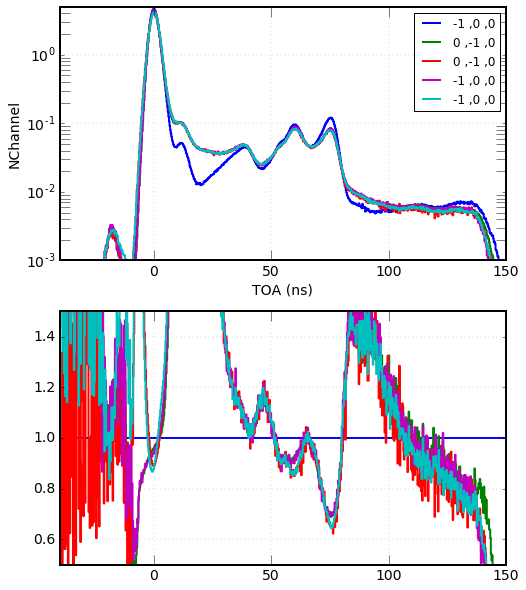

In [81]:
from itertools import cycle
colors = cycle(['b','g','r','m','c','y','darkblue','darkgreen','darkred'])
mymax = 100
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax)
for counter, fname in enumerate(test_files):
    thisb, thisx = getLaserballTOA(fname)
    if thisb.std() < 10000:
        print 'Skipping one file'
        continue
    
    position = getLaserballPosition(fname)

    
    print 'Position ', position
    
    info = getLaserballInfo(fname)
    
    try:
        print info['RSPS'].mean(), info['ChanEff'].mean()
    except:
        print 'Error with RSPS/ChanEff'
    
    #print run_info[counter]['cast'], run_info[counter]['lambda'], run_info[counter]['version']

    plt.axes(ax)
    str_pos = ' ,'.join(["%i" % x for x in position[:3]])
    thisb *= mymax/np.sum(thisb[1:])
    if counter == 0:
        refb = deepcopy(thisb)
        
    thiscolor = colors.next()
    
    jplot.unfilledBar(thisx, thisb , color = thiscolor, label = str_pos)
    
    plt.axes(ax2)
    jplot.unfilledBar(thisx, thisb/refb , color = thiscolor, label = str_pos)

    
plt.axes(ax)
plt.xlabel('TOA (ns)')
plt.ylabel('NChannel')
#plt.legend(loc=0)
plt.xlim([-40, 150])
plt.ylim(0.001, 5)
plt.yscale('log')

#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc=0)
plt.axes(ax2)
plt.ylim([0.5, 1.5])